In [2]:
# Install required system dependencies for displaying videos of OpenAI Gym.
!apt-get install -y xvfb x11-utils 
!apt-get install x11-utils > /dev/null 2>&1
!pip install PyVirtualDisplay==2.0.* \
  PyOpenGL==3.1.* \
  PyOpenGL-accelerate==3.1.* \
  gym[box2d]==0.17.* 
!pip install pyglet

Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [3]:
# Import Libraries
import gym
from gym import *
import numpy as np
import base64
import io
import IPython
import math
import sys
import cartpole_env
from cartpole_env import *
import collections
from mdp import MDP

# Discretise the Continuous Observation Space to Discrete States

In [67]:
num_intervals = 3 #6

In [68]:
# Discretise linear displacement
displacement_interval = np.linspace(-2.4, 2.4, num_intervals).astype(float)
displacement_interval

array([-2.4,  0. ,  2.4])

In [69]:
# Discretise linear velocity
velocity_interval = np.linspace(-3, 3, num_intervals).astype(float)
velocity_interval

array([-3.,  0.,  3.])

In [70]:
# Discretise angular displacement
theta_interval = np.linspace(-0.2,0.2, num_intervals).astype(float) 
theta_interval

array([-0.2,  0. ,  0.2])

In [71]:
# Discretise angular velocity
angular_velocity_interval = np.linspace(-3, 3, num_intervals).astype(float)
angular_velocity_interval

array([-3.,  0.,  3.])

In [72]:
def generate_states(displacement_interval, velocity_interval, theta_interval, angular_velocity_interval):
    all_disc_states = []
    for displacement in displacement_interval:
        for velocity in velocity_interval:
          for theta in theta_interval:
              for angular_velocity in angular_velocity_interval:
                  all_disc_states.append((displacement, velocity, theta, angular_velocity))
    return all_disc_states

In [73]:
# Generate states 
all_disc_states = generate_states(displacement_interval, velocity_interval, theta_interval, angular_velocity_interval)
print('The number of discrete state combinations is:', len(all_disc_states))
print('\nA sample of 10 discrete state combinations are:')
all_disc_states[:10]

The number of discrete state combinations is: 81

A sample of 10 discrete state combinations are:


[(-2.4, -3.0, -0.2, -3.0),
 (-2.4, -3.0, -0.2, 0.0),
 (-2.4, -3.0, -0.2, 3.0),
 (-2.4, -3.0, 0.0, -3.0),
 (-2.4, -3.0, 0.0, 0.0),
 (-2.4, -3.0, 0.0, 3.0),
 (-2.4, -3.0, 0.2, -3.0),
 (-2.4, -3.0, 0.2, 0.0),
 (-2.4, -3.0, 0.2, 3.0),
 (-2.4, 0.0, -0.2, -3.0)]

In [11]:
all_actions = np.array([0,1])
print('The actions consist of left (0) and right (1) movements:', all_actions)

The actions consist of left (0) and right (1) movements: [0 1]


In [12]:
def find_nearest_disc_value(array, value):
    # Returns the indices of the minimum values along an axis.
    i = (np.abs(array - value)).argmin()
    # Returns the corresponding value
    return array[i]

In [66]:
#find_nearest_disc_value(displacement_interval, 1)

0.0

In [13]:
def approximate_state(state, displacement_interval, velocity_interval, theta_interval, angular_velocity_interval):

    # Get the observed values for each variable.
    displacement = state[0]
    velocity = state[1]   
    theta = state[2]
    angular_velocity = state[3]

    # With the observed value, search and return the nearest discretised state from within the intervals. 
    disc_displacement = find_nearest_disc_value(displacement_interval, displacement)
    disc_velocity = find_nearest_disc_value(velocity_interval, velocity)
    disc_theta = find_nearest_disc_value(theta_interval, theta)
    disc_angular_velocity = find_nearest_disc_value(angular_velocity_interval, angular_velocity)

    return tuple([disc_displacement, disc_velocity, disc_theta, disc_angular_velocity])

# Generate Transitional Probability and Reward Matrices

In [14]:
'''
The following code loops through all discretised current states to then find the next state, reward and terminal variables.
The CartPoleEnv() class consists of a state argument in reset() which allows resettting the current state to any state to then find the next state.

The output is a transitional probabilty and rewards matrix of going from current state to next state given an action - this is utilised in linear policy iteration.
A dictionary of the transitional probability and rewards is also outputted for visualisation of the state-action MDP graph.
'''

# Initialise the CartPole class
cartpole_env = CartPoleEnv()

# Initialise lists 
current_trans_prob_reward_list_0 =[] # action - 0
current_trans_prob_reward_list_1 =[] # action - 1

# Initialise matrices
transition_prob_matrix = np.zeros((len(all_disc_states), len(all_disc_states), len(all_actions)))
reward_matrix = np.zeros(len(all_disc_states))

# Loop through all discretised states - these are the 'current' states
for i, disc_current_state in enumerate(all_disc_states):
  # Reset the state to input current state
  cartpole_env.reset(disc_current_state)
  # Loop through all actions
  for action in all_actions:
    # Step into the environment with given state and action and get the observation
    obs = cartpole_env.step(action) 
    # Unpack the observation into 'next' state, reward, done variables
    displacement = obs[0][0]
    velocity = obs[0][1]
    theta = obs[0][2]
    angularVelocity = obs[0][3]
    next_state = (displacement, velocity, theta, angularVelocity)
    reward = obs[1]
    done = obs[2]

    # Discretise the 'next' state and get the corresponding index from all discretised states combinations as well
    disc_next_state = approximate_state(next_state, displacement_interval, velocity_interval, theta_interval, angular_velocity_interval)
    j = all_disc_states.index(disc_next_state)
    
    # Get the mdp_tuples of the curr_state, action, next_state, reward
    mdp_tuple = disc_current_state, action, disc_next_state, reward
    # if action is 0, then append the tuple to the list and matrix for action 0, else append to action 1.
    if action == 0:
      current_trans_prob_reward_list_0.append(mdp_tuple)
      transition_prob_matrix[i][j][action]= 1
      reward_matrix[j]= reward
    if action == 1:
      current_trans_prob_reward_list_1.append(mdp_tuple)
      transition_prob_matrix[i][j][action]= 1  
      reward_matrix[j]= reward

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


# Visualisation with MDP
 Note: Only a sub-space is visualised with number of intervals for discretisation set to 3

In [286]:
# Intialise State-Action Transitional Probability Dictionary for Visualisation with MDP
transition_prob_dict = collections.defaultdict(dict)

# Add current states
transition_prob_dict = {str(s): {} for s in all_disc_states}

# Add actions
for key,value in transition_prob_dict.items():
  transition_prob_dict[key] = {str(a): {} for a in all_actions}

# Add next states and assign transition probabilty
for key,value in transition_prob_dict.items():
  transition_prob_dict[key]['0'] = {str(i[2]): 1 for i in current_trans_prob_reward_list_0 if key == str(i[0])}
  transition_prob_dict[key]['1'] = {str(i[2]): 1 for i in current_trans_prob_reward_list_1 if key == str(i[0])}

print(transition_prob_dict)

{'(-2.4, -3.0, -0.2, -3.0)': {'0': {'(-2.4, -3.0, -0.2, -3.0)': 1}, '1': {'(-2.4, -3.0, -0.2, -3.0)': 1}}, '(-2.4, -3.0, -0.2, 0.0)': {'0': {'(-2.4, -3.0, -0.2, 0.0)': 1}, '1': {'(-2.4, -3.0, -0.2, 0.0)': 1}}, '(-2.4, -3.0, -0.2, 3.0)': {'0': {'(-2.4, -3.0, -0.2, 3.0)': 1}, '1': {'(-2.4, -3.0, 0.0, 3.0)': 1}}, '(-2.4, -3.0, 0.0, -3.0)': {'0': {'(-2.4, -3.0, 0.0, -3.0)': 1}, '1': {'(-2.4, -3.0, -0.2, -3.0)': 1}}, '(-2.4, -3.0, 0.0, 0.0)': {'0': {'(-2.4, -3.0, 0.0, 0.0)': 1}, '1': {'(-2.4, -3.0, 0.0, 0.0)': 1}}, '(-2.4, -3.0, 0.0, 3.0)': {'0': {'(-2.4, -3.0, 0.0, 3.0)': 1}, '1': {'(-2.4, -3.0, 0.2, 3.0)': 1}}, '(-2.4, -3.0, 0.2, -3.0)': {'0': {'(-2.4, -3.0, 0.2, -3.0)': 1}, '1': {'(-2.4, -3.0, 0.0, -3.0)': 1}}, '(-2.4, -3.0, 0.2, 0.0)': {'0': {'(-2.4, -3.0, 0.2, 0.0)': 1}, '1': {'(-2.4, -3.0, 0.2, 0.0)': 1}}, '(-2.4, -3.0, 0.2, 3.0)': {'0': {'(-2.4, -3.0, 0.2, 3.0)': 1}, '1': {'(-2.4, -3.0, 0.2, 3.0)': 1}}, '(-2.4, 0.0, -0.2, -3.0)': {'0': {'(-2.4, 0.0, -0.2, -3.0)': 1}, '1': {'(-2.4, 0.

In [287]:
# Intialise State-based Rewards Dictionary for Visualisation with MDP
rewards_dict = collections.defaultdict(dict)

# Add current states
rewards_dict = {str(s): {} for s in all_disc_states}

# Add actions
for key,value in rewards_dict.items():
  rewards_dict[key] = {str(a): {} for a in all_actions}

# Add next states and assign transition probabilty
for key,value in rewards_dict.items():
  rewards_dict[key]['0'] = {str(i[2]): i[3] for i in current_trans_prob_reward_list_0 if key == str(i[0])}
  rewards_dict[key]['1'] = {str(i[2]): i[3] for i in current_trans_prob_reward_list_1 if key == str(i[0])}

print(rewards_dict)

{'(-2.4, -3.0, -0.2, -3.0)': {'0': {'(-2.4, -3.0, -0.2, -3.0)': 1.0}, '1': {'(-2.4, -3.0, -0.2, -3.0)': 0.0}}, '(-2.4, -3.0, -0.2, 0.0)': {'0': {'(-2.4, -3.0, -0.2, 0.0)': 1.0}, '1': {'(-2.4, -3.0, -0.2, 0.0)': 0.0}}, '(-2.4, -3.0, -0.2, 3.0)': {'0': {'(-2.4, -3.0, -0.2, 3.0)': 1.0}, '1': {'(-2.4, -3.0, 0.0, 3.0)': 0.0}}, '(-2.4, -3.0, 0.0, -3.0)': {'0': {'(-2.4, -3.0, 0.0, -3.0)': 1.0}, '1': {'(-2.4, -3.0, -0.2, -3.0)': 0.0}}, '(-2.4, -3.0, 0.0, 0.0)': {'0': {'(-2.4, -3.0, 0.0, 0.0)': 1.0}, '1': {'(-2.4, -3.0, 0.0, 0.0)': 0.0}}, '(-2.4, -3.0, 0.0, 3.0)': {'0': {'(-2.4, -3.0, 0.0, 3.0)': 1.0}, '1': {'(-2.4, -3.0, 0.2, 3.0)': 0.0}}, '(-2.4, -3.0, 0.2, -3.0)': {'0': {'(-2.4, -3.0, 0.2, -3.0)': 1.0}, '1': {'(-2.4, -3.0, 0.0, -3.0)': 0.0}}, '(-2.4, -3.0, 0.2, 0.0)': {'0': {'(-2.4, -3.0, 0.2, 0.0)': 1.0}, '1': {'(-2.4, -3.0, 0.2, 0.0)': 0.0}}, '(-2.4, -3.0, 0.2, 3.0)': {'0': {'(-2.4, -3.0, 0.2, 3.0)': 1.0}, '1': {'(-2.4, -3.0, 0.2, 3.0)': 0.0}}, '(-2.4, 0.0, -0.2, -3.0)': {'0': {'(-2.4, 0.0

In [289]:
import mdp
from mdp import MDP

In [290]:
# Generate the visualisation from the MDP data 
mdp = MDP(transition_prob_dict, rewards_dict, initial_state=str((-2.4, -3.0, -0.2, -3.0)))

Graphviz available: True


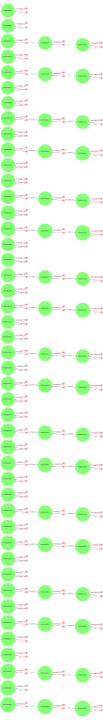

In [291]:
# Visualise the MDP
from mdp import has_graphviz
from IPython.display import display
print("Graphviz available:", has_graphviz)

if has_graphviz:
    from mdp import plot_graph, plot_graph_with_state_values, plot_graph_optimal_strategy_and_state_values
    display(plot_graph(mdp))

# Policy Iteration Using Linear Programming to Find Exact Solution

In [55]:
def exact_linear_policy_evaluation(policy, reward_matrix, transition_prob_matrix, gamma, states, actions):
    # For each state and recommended policy, compute the expected value using Bellman's Equation.
    value_function = np.zeros(len(states))
    for state in range(len(states)):
        action = policy[state]
        value_function[state] = np.linalg.solve(np.identity(len(states)) - gamma * transition_prob_matrix[:, :, action], reward_matrix) [state]
    return value_function

def expected_action(value_function, transition_prob_matrix, current_state, actions):
    # For each action, compute the expected value for given state.
    action_values = np.zeros(len(actions))
    for action in range(len(actions)):
         action_values[action] = np.sum(np.multiply(value_function, np.dot(current_state, transition_prob_matrix[:,:,action])))
    return action_values

def exact_policy_iteration(actions, states, gamma, transition_prob_matrix, reward_matrix):
    counter = 0
    prev_value_function = 0

    # Initialise starting policy 
    policy = np.random.randint(0, len(actions), size=(len(states))) 

    while True:
        counter += 1

        # Step One: Policy Evaluation computes and stores the value function for each state given the policy.
        value_function = exact_linear_policy_evaluation(policy, reward_matrix, transition_prob_matrix, gamma, states, actions)
        prev_value_function = np.sum(value_function)

        # Initialise a flag for given state to indicate if the policy has changed.
        same_policy = True
        
        for state in range(len(states)):
            # Current state is the state for which policy is evaluated.
            current_state = np.zeros((1, len(states)))
            current_state[0, state] = 1.0
        
            # Step Two: Policy Improvement computes expected value for the actions in the current state.
            action_expected_value = expected_action(value_function, transition_prob_matrix, current_state, actions)
            greedy_action_value = np.max(action_expected_value)
            greedy_action = np.argmax(action_expected_value)  

            if greedy_action != policy[state]:
                # Check if the value for the value from the new action is greater than the current policy's, and if so update policy for given state.         
                if greedy_action_value > value_function[state]:
                    policy[state] = greedy_action
                    same_policy = False
        
        print("Iteration:", counter, ", Policy Value:", np.sum(value_function))    

        if same_policy:
            break
    
    return policy

def get_optimal_action(state, optimal_policy, states, actions):
    # Find the given state's index from the discretised list of states and obtain the optimal policy for the same index.
    stateIdx = states.index(state)
    action = optimal_policy[stateIdx]
    optimal_action = actions[action]

    return optimal_action

In [56]:
# Initialise discount factor
gamma = 0.9999

# Calculate optimal policy
optimal_policy = exact_policy_iteration(all_actions, all_disc_states, gamma, transition_prob_matrix, reward_matrix)
optimal_policy

Iteration: 1 , Policy Value: 510014.99960005615
Iteration: 2 , Policy Value: 510014.99960005615
Iteration: 3 , Policy Value: 510014.99960005615


array([1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0])

In [57]:
# Save optimal policy
np.save("optimal_policy_v1", optimal_policy)

# Results

In [58]:
# Load optimal policy
optimal_policy = np.load("policy.npy")

In [58]:
# Remove existing video
!rm ./vid/*.* 

from gym.wrappers import Monitor
from IPython import display
from pyvirtualdisplay import Display

d = Display()
d.start()

env = gym.make('CartPole-v0')
env = Monitor(env,'./vid',force=True)

total_reward = 0
num_episodes = 5 
timesteps = 200
counter = 0

for episode in range(0, num_episodes):
    observation = env.reset()
    episode_reward = 0
    done = False
    # Each episode consists of 200 timesteps, after which the environment automatically terminates.
    for timestep in range(0, timesteps):
        counter += 1
        env.render()
        # Obtain the optimal action for the current observation.
        action = get_optimal_action(approximate_state([observation[0], observation[1], observation[2], observation[3]], displacement_interval, velocity_interval, theta_interval, angular_velocity_interval), optimal_policy, all_disc_states, all_actions)
        # Step into optimal policy/action.
        observation, reward, done, info = env.step(action)
        # Add current reward
        episode_reward += reward
        if done:
            print('Episode:', episode, 'Episode reward:', episode_reward)
            total_reward += episode_reward
            break

print("Number of timesteps:", counter)
print("\nTotal reward for", counter, "timesteps =", total_reward)
print("Average reward per", counter, "timesteps =", total_reward/counter)

env.close

Episode 0: Episode reward: 29.0
Episode 1: Episode reward: 22.0
Episode 2: Episode reward: 144.0
Episode 3: Episode reward: 107.0
Episode 4: Episode reward: 166.0
Iterations: 468

Total reward for 468 timesteps = 468.0
Average reward per 468 timesteps = 1.0


<bound method Monitor.close of <Monitor<TimeLimit<CartPoleEnv<CartPole-v0>>>>>

In [ ]:
# Run the video
for f in env.videos:
    video = io.open(f[0], 'r+b').read()
    encoded = base64.b64encode(video)

    display.display(display.HTML(data="""
        <video alt="test" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4" />
        </video>
        """.format(encoded.decode('ascii'))))

# Convert to HTML

In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

In [62]:
!jupyter nbconvert --to HTML /content/SIT796_3_1D.ipynb

[NbConvertApp] Converting notebook /content/SIT796_3_1D.ipynb to HTML
[NbConvertApp] Writing 687273 bytes to /content/SIT796_3_1D.html
